In [ ]:
# import all necessary packages for SS_LSTM
! pip install -q datasets
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import collections
import itertools
import re
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from torchtext.vocab import GloVe
from datasets import load_dataset
from sklearn.metrics import accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64",

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Load Dataset from Hugging Face

In [ ]:
# Load the data from PiC dataset

def load_data():
    dataset = load_dataset("PiC/phrase_similarity")
    train_data = dataset["train"]
    val_data = dataset["validation"]
    test_data = dataset["test"]
    return train_data, val_data, test_data


In [ ]:
# Load datasets
ltrain_dataset, lval_dataset, ltest_dataset = load_data()

Generating train split:   0%|          | 0/7004 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Check datasets
print(len(ltrain_dataset))
print(len(lval_dataset))
print(len(ltest_dataset))

7004
1000
2000


In [ ]:
class Preprocess():
    def __init__(self, sentences):
        self.sentences = sentences

    def tokenize(self):
        self.sentences = [word_tokenize(sentence) for sentence in self.sentences]

    def lowercase(self):
        self.sentences = [[word.lower() for word in sentence] for sentence in self.sentences]

    def remove_stop_words(self):
        stop_words = set(stopwords.words('english'))
        self.sentences = [[word for word in sentence if word not in stop_words] for sentence in self.sentences]

    def stemmer(self):
        stemmer = nltk.stem.PorterStemmer()
        self.sentences = [[stemmer.stem(word) for word in sentence] for sentence in self.sentences]

    def remove_punctuation(self):
        self.sentences = [[word for word in sentence if word.isalpha()] for sentence in self.sentences]

    def remove_numbers(self):
        self.sentences = [[word for word in sentence if not word.isdigit()] for sentence in self.sentences]

    def remove_single_letter(self):
        self.sentences = [[word for word in sentence if len(word) > 1] for sentence in self.sentences]

    def remove_extra_spaces(self):
        self.sentences = [[word for word in sentence if word != ' '] for sentence in self.sentences]

    def remove_less_than_3(self):
        self.sentences = [[word for word in sentence if len(word) > 2] for sentence in self.sentences]

    def run_all(self):
        self.tokenize()
        self.lowercase()
        self.remove_stop_words()
        self.stemmer()
        self.remove_punctuation()
        self.remove_numbers()
        self.remove_single_letter()
        self.remove_extra_spaces()
        self.remove_less_than_3()
        return self.sentences

In [ ]:
# Load the GloVe embeddings
glove = GloVe(name='6B')
print(glove.vectors.shape)

torch.Size([400000, 300])


In [ ]:
# if 'unk' not in glove.stoi:
#     glove.stoi['unk'] = len(glove.stoi)  # Add 'unk' token
#     unk_vector = torch.mean(glove.vectors, dim=0)  # Use mean of all vectors as unk vector
#     glove.vectors = torch.cat([glove.vectors, unk_vector.unsqueeze(0)], dim=0)

print(glove.stoi['unk'])

201534


In [ ]:
def sentence_to_indices(sentence, glove, max_len):
    preprocess = Preprocess([sentence])
    # print(sentence)
    sentence = preprocess.run_all()[0]
    length = len(sentence)
    indices = [glove.stoi[word] if word in glove.stoi else glove.stoi['unk'] for word in sentence]
    padded_indices = indices[:max_len] + [0] * (max_len - len(indices))
    flength = length if length < max_len else max_len
    return padded_indices, max_len

def process_dataset(dataset, glove, max_lens, max_lenp):
    processed_data = []
    for item in dataset:
        # print(item['id'])
        sentence1_indices, _ = sentence_to_indices(item['sentence1'], glove, max_lens)
        sentence2_indices, _ = sentence_to_indices(item['sentence2'], glove, max_lens)
        phrase1_indices, _ = sentence_to_indices(item['phrase1'], glove, max_lenp)
        phrase2_indices, _ = sentence_to_indices(item['phrase2'], glove, max_lenp)
        label = torch.tensor(item['label'], dtype=torch.long)
        sentence1_tensor = torch.tensor(sentence1_indices, dtype=torch.long)
        sentence2_tensor = torch.tensor(sentence2_indices, dtype=torch.long)
        processed_data.append((sentence1_indices, sentence2_indices, phrase1_indices, phrase2_indices, max_lens, max_lens, max_lenp, max_lenp, label))
    return processed_data

def collate_fn(batch):
    sentence1_batch = torch.tensor([item[0] for item in batch])
    sentence2_batch = torch.tensor([item[1] for item in batch])
    phrase1_batch = torch.tensor([item[2] for item in batch])
    phrase2_batch = torch.tensor([item[3] for item in batch])
    len1_batch = torch.tensor([item[4] for item in batch])
    len2_batch = torch.tensor([item[5] for item in batch])
    lenp1_batch = torch.tensor([item[6] for item in batch])
    lenp2_batch = torch.tensor([item[7] for item in batch])
    labels_batch = torch.tensor([item[8] for item in batch])
    return sentence1_batch, sentence2_batch, phrase1_batch, phrase2_batch, len1_batch, len2_batch, lenp1_batch, lenp2_batch, labels_batch


In [ ]:
# Get the dataset
train_dataset = process_dataset(ltrain_dataset, glove, 34,11)
val_dataset = process_dataset(lval_dataset, glove, 34,11)
test_dataset = process_dataset(ltest_dataset, glove, 34,11)

In [ ]:
# Check the dataset
print(train_dataset[1])
print(val_dataset[0])
print(test_dataset[0])

([2733, 48, 933, 68, 6923, 201534, 38883, 201534, 201534, 201534, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2733, 1671, 109429, 68, 6923, 201534, 38883, 201534, 201534, 201534, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [48, 933, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1671, 109429, 0, 0, 0, 0, 0, 0, 0, 0, 0], 34, 34, 11, 11, tensor(1))
([15599, 183949, 336, 201534, 201534, 58, 180020, 156, 1143, 201534, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [15599, 183949, 336, 201534, 201534, 3600, 1480, 156, 1143, 201534, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [58, 180020, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3600, 1480, 0, 0, 0, 0, 0, 0, 0, 0, 0], 34, 34, 11, 11, tensor(0))
([19281, 1863, 2609, 325, 78647, 7758, 681, 515, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [19281, 1863, 2609, 201534, 3106, 7758, 681, 515, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

In [ ]:
# # Check the dataloaders

print(len(train_loader))

for batch in train_loader:
    print(len(batch))
    break

55
9


In [ ]:
# class for Attention
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_output, phrase_fs):
        key = self.linear(phrase_fs)
        key = key.unsqueeze(2)

        energy = torch.bmm(encoder_output, key)
        energy = energy.squeeze(2)
        attention = self.softmax(energy)
        attention = attention.unsqueeze(2)

        context = torch.bmm(encoder_output.transpose(1,2), attention)
        # context = context.squeeze(2)
        # print(context.shape)
        return context, attention


In [ ]:
# Siamise LSTM model
class PS_LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(PS_LSTM, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(len(glove.vectors), embedding_dim)
        self.embedding.weight.data.copy_(glove.vectors)
        self.embedding.weight.requires_grad = False # Freeze embeddings
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=3, dropout=0.5)
        self.fc = nn.Linear(4*hidden_dim, 1)
        self.dropout = nn.Dropout(0.5)
        self.attention = Attention(hidden_dim*2)

    def lstm_forward(self, x, length):
        x = self.embedding(x)
        x = torch.nn.utils.rnn.pack_padded_sequence(x, length, batch_first=True, enforce_sorted=False)
        lout, _ = self.lstm(x)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(lout, batch_first=True)
        return out

    def lstm_fs(self, x, length):
        x = self.embedding(x)
        x = torch.nn.utils.rnn.pack_padded_sequence(x, length, batch_first=True, enforce_sorted=False)
        # Get the final state
        _, (h, _) = self.lstm(x)
        h = torch.cat((h[-2,:,:], h[-1,:,:]), dim=1)
        return h

    def forward(self, batch):
        # Get the sentence pair, phrase pair and length
        sentence1, sentence2, phrase1, phrase2, len1, len2, lenp1, lenp2, _ = batch

        # Get the LSTM output for sentences
        soutput1 = self.lstm_forward(sentence1, len1)
        soutput2 = self.lstm_forward(sentence2, len2)

        # Get phrase emeddings
        poutput1 = self.lstm_fs(phrase1, lenp1)
        poutput2 = self.lstm_fs(phrase2, lenp2)

        # Get the attention context
        context1, _ = self.attention(soutput1, poutput1)
        context2, _ = self.attention(soutput2, poutput2)

        # Dropout


        # Concatenate the outputs

        # concat_output1 = torch.cat((context1, self.embedding(phrase1)), dim=1)
        # concat_output2 = torch.cat((context2, self.embedding(phrase2)), dim=1)
        output = torch.cat((context1, context2), dim=1)
        output = output.squeeze(-1)

        # Get the final output
        output = self.fc(output)
        output = torch.sigmoid(output)

        return output


In [ ]:
# Set the hyperparameters
embedding_dim = 300
hidden_dim = 50
lr = 0.01
epochs = 10

# Initialize the model
model = PS_LSTM(embedding_dim, hidden_dim)
model.to(device)

# Define the loss function for binary classification
criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# print(len(glove.vectors))


In [ ]:
# Function for train
def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_preds = []
        labels = []
        train_loss = 0.0
        val_loss = 0.0
        model.train()
        for batch in tqdm(train_loader):
            batch = [b.to(device) if i != 4 and i != 5 and i!=6 and i!=7 else b for i, b in enumerate(batch)]
            # Get the output from the model
            # output1, output2 = model(batch)
            output = model(batch)

            # Get the label
            _, _, _, _, _, _, _, _, label = batch
            label = label.float()

            # Calculate the loss

            # output1 = F.normalize(output1, p=2, dim=1) # Normalize the output
            # output2 = F.normalize(output2, p=2, dim=1) # Normalize the output

            # cosine_similarity = F.cosine_similarity(output1, output2)
            # Round cosine similarity to 6 decimal places
            # cosine_similarity = torch.round(cosine_similarity * 1000000) / 1000000

            # Map the similarity to 0 or 1
            # similarity = F.sigmoid(cosine_similarity) # Non-linear mapping
            # similarity = (cosine_similarity + 1)/2 # Linear mapping
            # print("Similarity range: min =", similarity.min().item(), "max =", similarity.max().item())

            # distance = F.mse_loss(output1, output2, reduction='none')
            # distance = torch.sum(distance, dim=1)
            # similarity = F.sigmoid(-distance)

            similarity = output.squeeze()

            loss = criterion(similarity, label)

            # Backpropagate the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the train loss
            train_loss += loss.item()

            # Get the predictions
            preds = [1 if x >= 0.5 else 0 for x in similarity]
            train_preds.extend(preds)
            # Detach the label from GPU
            label = label.detach().cpu().numpy()
            labels.extend(label)

        # Calculate the average loss
        train_loss = train_loss/len(train_loader)
        train_losses.append(train_loss)

        # Calculate the validation loss
        model.eval()
        for batch in tqdm(val_loader):
            batch = [b.to(device) if i != 4 and i != 5 and i!=6 and i!=7 else b for i, b in enumerate(batch)]
            # Get the output from the model
            # output1, output2 = model(batch)
            output = model(batch)

            # Get the label
            _, _, _, _, _, _, _, _, label = batch
            label = label.float()

            # Calculate the loss

            # cosine_similarity = F.cosine_similarity(output1, output2)
            # Map the similarity to 0 or 1
            # similarity = F.sigmoid(cosine_similarity) # Non-linear mapping

            similarity = output.squeeze()
            loss = criterion(similarity, label)

            # Update the validation loss
            val_loss += loss.item()

        # Calculate the average loss
        val_loss = val_loss/len(val_loader)
        val_losses.append(val_loss)

        # Calculate the accuracy
        train_acc = accuracy_score(train_preds, labels)

        # Print the losses and accuracy
        print("Epoch:", epoch+1, "Train Loss:", train_loss, "Val Loss:", val_loss, "Train Accuracy:", train_acc)

    return train_losses, val_losses

In [ ]:
# Train the model

train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, epochs)

100%|██████████| 8/8 [00:00<00:00, 73.94it/s]


Epoch: 1 Train Loss: 0.6967644734816117 Val Loss: 0.6931660175323486 Train Accuracy: 0.4935750999428898


100%|██████████| 8/8 [00:00<00:00, 55.73it/s]


Epoch: 2 Train Loss: 0.6935364213856784 Val Loss: 0.6932666748762131 Train Accuracy: 0.49785836664762995


100%|██████████| 8/8 [00:00<00:00, 78.29it/s]


Epoch: 3 Train Loss: 0.6932262279770591 Val Loss: 0.6933166459202766 Train Accuracy: 0.49671616219303255


100%|██████████| 8/8 [00:00<00:00, 86.91it/s]


Epoch: 4 Train Loss: 0.6932325243949891 Val Loss: 0.6935293972492218 Train Accuracy: 0.5039977155910909


100%|██████████| 8/8 [00:00<00:00, 89.51it/s]


Epoch: 5 Train Loss: 0.6933793100443754 Val Loss: 0.693386048078537 Train Accuracy: 0.49414620217018845


100%|██████████| 8/8 [00:00<00:00, 87.00it/s]


Epoch: 6 Train Loss: 0.6933221676132896 Val Loss: 0.6936245933175087 Train Accuracy: 0.5067104511707595


100%|██████████| 8/8 [00:00<00:00, 87.69it/s]


Epoch: 7 Train Loss: 0.6932558189738881 Val Loss: 0.6931852400302887 Train Accuracy: 0.500856653340948


100%|██████████| 8/8 [00:00<00:00, 75.11it/s]


Epoch: 8 Train Loss: 0.693237042427063 Val Loss: 0.6931815594434738 Train Accuracy: 0.4920045688178184


100%|██████████| 8/8 [00:00<00:00, 53.62it/s]


Epoch: 9 Train Loss: 0.6933011163364757 Val Loss: 0.6931558772921562 Train Accuracy: 0.4840091376356368


100%|██████████| 8/8 [00:00<00:00, 55.51it/s]

Epoch: 10 Train Loss: 0.6932391632686962 Val Loss: 0.6931562349200249 Train Accuracy: 0.49557395773843516


In [ ]:
# Function to plot the losses: train and validation on the same plot
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/ps_bilstm_attention_losses.png')
    plt.show()

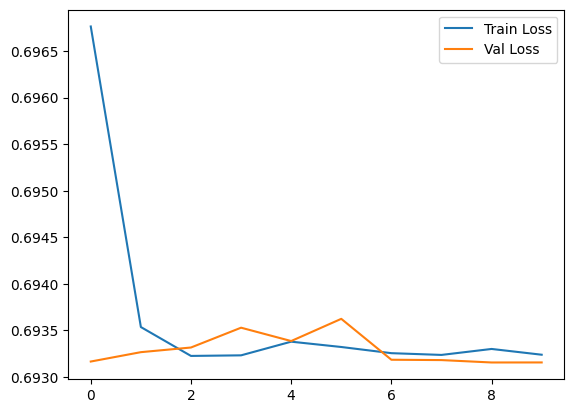

In [ ]:
# Call the function to plot the losses
plot_losses(train_losses, val_losses)

In [ ]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/ps_bilstm_attention_losses.pth')

In [ ]:
# Function for test
def evaluate(model, test_loader, criterion):
    test_loss = 0.0
    model.eval()
    predictions = []
    labels = []

    for batch in tqdm(test_loader):
        batch = [b.to(device) if i != 4 and i != 5 and i!=6 and i!=7 else b for i, b in enumerate(batch)]
        # Get the output from the model
        # output1, output2 = model(batch)
        output = model(batch)

        # Get the label
        _, _, _, _, _, _, _, _, label = batch
        label = label.float()

        # Calculate the loss

        # cosine_similarity = F.cosine_similarity(output1, output2)
        # Round cosine similarity to 6 decimal places
        # cosine_similarity = torch.round(cosine_similarity * 1000000) / 1000000

        # Map the similarity to 0 or 1
        # similarity = F.sigmoid(cosine_similarity) # Non-linear mapping
        # similarity = (cosine_similarity + 1)/2 # Linear mapping

        similarity = output.squeeze()

        predicted_label = [1 if x >= 0.49 else 0 for x in similarity]
        predictions.extend(predicted_label)

        loss = criterion(similarity, label)

        label = label.detach().cpu().numpy()
        labels.extend(label.tolist())

        # Update the test loss
        test_loss += loss.item()

    # Calculate the average loss
    test_loss = test_loss/len(test_loader)

    # Print the losses
    print('Test Loss: {:.6f}'.format(test_loss))

    # Calculate the accuracy
    accuracy = accuracy_score(labels, predictions)

    return test_loss, accuracy * 100

In [ ]:
# Evaluate the model

test_loss, accuracy = evaluate(model, test_loader, criterion)
print('Accuracy: {:.6f}'.format(accuracy))

100%|██████████| 16/16 [00:00<00:00, 51.91it/s]

Test Loss: 0.693153
Accuracy: 50.000000
